In [209]:
import torch
import torchvision
import torchvision.transforms as transforms
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

train_transform = transforms.Compose([
     transforms.ColorJitter(brightness=0.5),
     transforms.RandomRotation(degrees=45),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomCrop(32, padding=4),
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

test_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

batch_size = 5
ap_num, am_num,bird_num,cat_num,deer_num = 0,0,0,0,0

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=train_transform)
ap_indices, am_indices, bird_indices, cat_indices, deer_indices = [],[],[],[],[]
ap_idx, am_idx, bird_idx, cat_idx, deer_idx = trainset.class_to_idx['airplane'], trainset.class_to_idx['automobile'], trainset.class_to_idx['bird'], trainset.class_to_idx['cat'], trainset.class_to_idx['deer']
for i in range(len(trainset)):
  current_class = trainset[i][1]
  if current_class == ap_idx:
    if ap_num<50:
      ap_indices.append(i)
      ap_num+=1
  elif current_class == am_idx:
    if am_num<50:
      am_indices.append(i)
      am_num+=1
  elif current_class == bird_idx:
    if bird_num<50:
      bird_indices.append(i)
      bird_num+=1
  elif current_class == cat_idx:
    if cat_num<50:
      cat_indices.append(i)
      cat_num+=1
  elif current_class == deer_idx:
    if deer_num<50:
      deer_indices.append(i)
      deer_num+=1

print('Number of airplane images:%d'%ap_num)
print('Number of automobile images:%d'%am_num)
print('Number of bird images:%d'%bird_num)
print('Number of cat images:%d'%cat_num)
print('Number of deer images:%d'%deer_num)

new_train = torch.utils.data.Subset(trainset,ap_indices+am_indices+bird_indices+cat_indices+deer_indices)

trainloader = torch.utils.data.DataLoader(new_train, batch_size = batch_size,
                                          shuffle=True, num_workers=2)

ap_num, am_num,bird_num,cat_num,deer_num = 0,0,0,0,0

testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=test_transform)
ap_indices, am_indices, bird_indices, cat_indices, deer_indices = [],[],[],[],[]
ap_idx, am_idx, bird_idx, cat_idx, deer_idx = testset.class_to_idx['airplane'], testset.class_to_idx['automobile'], testset.class_to_idx['bird'], testset.class_to_idx['cat'], testset.class_to_idx['deer']
for i in range(len(testset)):
  current_class = testset[i][1]
  if current_class == ap_idx:
    if ap_num<30:
      ap_indices.append(i)
      ap_num+=1
  elif current_class == am_idx:
    if am_num<30:
      am_indices.append(i)
      am_num+=1
  elif current_class == bird_idx:
    if bird_num<30:
      bird_indices.append(i)
      bird_num+=1
  elif current_class == cat_idx:
    if cat_num<30:
      cat_indices.append(i)
      cat_num+=1
  elif current_class == deer_idx:
    if deer_num<30:
      deer_indices.append(i)
      deer_num+=1

print('Number of airplane images:%d'%ap_num)
print('Number of automobile images:%d'%am_num)
print('Number of bird images:%d'%bird_num)
print('Number of cat images:%d'%cat_num)
print('Number of deer images:%d'%deer_num)

new_test = torch.utils.data.Subset(testset,ap_indices+am_indices+bird_indices+cat_indices+deer_indices)

testloader = torch.utils.data.DataLoader(new_test, batch_size = batch_size,
                                         shuffle=False, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer')
           

Files already downloaded and verified
Number of airplane images:50
Number of automobile images:50
Number of bird images:50
Number of cat images:50
Number of deer images:50
Files already downloaded and verified
Number of airplane images:30
Number of automobile images:30
Number of bird images:30
Number of cat images:30
Number of deer images:30


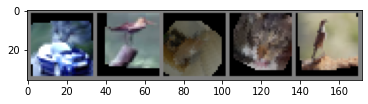

automobile  bird   cat   cat  bird


In [210]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' %classes[labels[j]] for j in range(batch_size)))

In [211]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
net = Net()

In [212]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [214]:
for epoch in range(15):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i%50 == 49:
            print('[%d, %5d] loss:%.3f'%(epoch+1,i+1,running_loss/50))
            running_loss =0.0

print('Finished Training')


[1,    50] loss:1.601
[2,    50] loss:1.594
[3,    50] loss:1.598
[4,    50] loss:1.591
[5,    50] loss:1.581
[6,    50] loss:1.583
[7,    50] loss:1.557
[8,    50] loss:1.554
[9,    50] loss:1.559
[10,    50] loss:1.563
[11,    50] loss:1.536
[12,    50] loss:1.510
[13,    50] loss:1.508
[14,    50] loss:1.465
[15,    50] loss:1.450
Finished Training


In [215]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

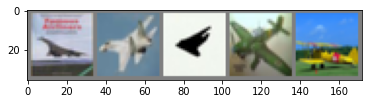

GroundTruth: airplane airplane airplane airplane airplane 


In [216]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth:',''.join('%5s ' % classes[labels[j]] for j in range(batch_size)))

In [217]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [218]:
outputs = net(images)

In [219]:
_, predicted = torch.max(outputs,1)

print('Predicted: ', ''.join('%5s' % classes[predicted[j]] for j in range(batch_size)))

Predicted:  airplaneairplaneairplaneautomobileairplane


In [220]:
correct = 0
total = 0

with torch.no_grad():
   for data in testloader:
       images, labels = data
       outputs = net(images)
       _, predicted = torch.max(outputs.data, 1)
       total += labels.size(0)
       correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' %(100*correct/total)) 



Accuracy: 42 %


In [221]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs,1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100*float(correct_count)/total_pred[classname]
    print('Accuracy for class {:5s} is : {:.1f} %'.format(classname,accuracy))

Accuracy for class airplane is : 80.0 %
Accuracy for class automobile is : 53.3 %
Accuracy for class bird  is : 6.7 %
Accuracy for class cat   is : 16.7 %
Accuracy for class deer  is : 53.3 %


In [222]:
device = torch.device('cuda:0' if torch.cuda.is_available()else 'cpu')
print(device)

cuda:0
